# Хакатон ЯКомпании (промежуточный этап)

[Ссылка на сдачу](https://apps.skillfactory.ru/learning/course/course-v1:SkillFactory+TGUAI+SEP_2023/block-v1:SkillFactory+TGUAI+SEP_2023+type@sequential+block@ba7915b70d2143aa9546a6b2a9add87d/block-v1:SkillFactory+TGUAI+SEP_2023+type@vertical+block@b36b75cab89e4f449f296803f488a9f6?homework=5289)

Команда 3:

Рогов И.	rogovins@mail.ru

Смирнов Ю.	h4rdwork@yandex.ru

Стрыгин Д. d.strygin@mail.ru


Предварительная (планируемая) идея схемы работы:

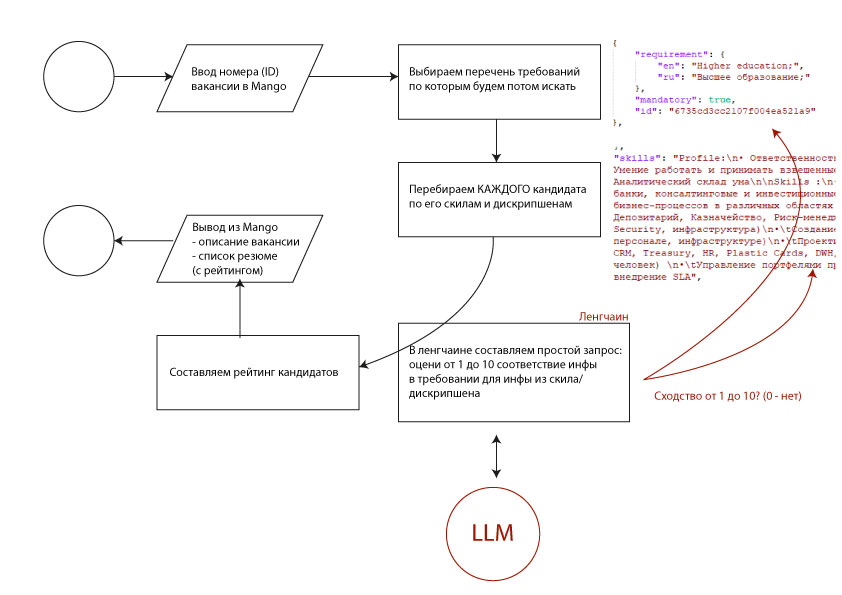

# Работа с Манго БД
Заказчик дал доступ к тестовой БД

(для работы необходимо подгрузить в Колаб файлы доступа к БД: root_ca.crt и tguai.pem)

In [ ]:
!pip install pymongo pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 23.0 MB/s eta 0:00:00


Код для пробы подключения к БД и анализа структуры БД

In [ ]:
from pymongo import MongoClient
import pandas as pd

# Параметры подключения
uri = "mongodb://mongodb01.kube01.icncd.ru:27017/imarketplacetesting?authSource=$external&authMechanism=MONGODB-X509"

# Путь к файлу сертификата клиента (ключевой файл)
client_cert_file = '/content/tguai.pem'  # Загруженный в локальный корень файл

# Путь к файлу корневого сертификата
ca_file = '/content/root_ca.crt'  # Загруженный в локальный корень файл

# Настройка параметров SSL для подключения
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile=client_cert_file,
                     tlsCAFile=ca_file)

# Получить базу данных
db = client['imarketplacetesting']

# Перечислить коллекции в базе данных
collections = db.list_collection_names()
print("Collections in the database:", collections)

# Визуализировать первые несколько документов из каждой коллекции
for collection_name in collections:
    print(f"\nCollection: {collection_name}")
    collection = db[collection_name]
    # Извлечь первые 5 документов
    documents = list(collection.find().limit(5))
    # Преобразовать данные в DataFrame для удобства чтения
    df = pd.DataFrame(documents)
    print(df)

Collections in the database: ['payload-locked-documents', 'offerstatuses', 'skills', 'payload-preferences', 'specializations', 'assistants', 'categories', 'payload-migrations', 'seeds', 'jobs', 'admins', 'media', 'locations', 'users', 'projects', 'posts', 'specialists', 'parsedspecialists', 'businessareas', 'permissions', 'industries', 'roles', 'services', 'grades', 'globals', 'offers', '_specialist_versions', 'parsinghistories', 'countries', 'embeddings', 'companies', 'messages', 'cities', 'businessentities', 'languages']

Collection: payload-locked-documents
                        _id  \
0  67169abb78946747988db404   

                                            document  \
0  {'relationTo': ['message'], 'value': '671694cf...   

                                                user               createdAt  \
0  {'relationTo': ['admin'], 'value': '66cefb133f... 2024-10-21 18:17:31.369   

                updatedAt  __v  
0 2024-10-21 18:17:31.369    0  

Collection: offerstatuses
   

**база данных MongoDB содержит следующие коллекции:**

```
payload-locked-documents
offerstatuses
skills
payload-preferences
specializations
assistants
categories
payload-migrations
seeds
jobs
admins
media
locations
users
projects
posts
specialists
parsedspecialists
businessareas
permissions
industries
roles
services
grades
globals
offers
_specialist_versions
parsinghistories
countries
embeddings
companies
messages
cities
businessentities
languages

```



**Анализ содержимого**

Резюме кандидатов: Находятся в коллекции parsedspecialists.

Эта коллекция содержит поля с resumeId, data, status, и результаты парсинга, что говорит о том, что здесь хранятся данные, которые были извлечены из резюме кандидатов.


Collection: parsedspecialists
```
- `_id`
- `resumeId`
- `data`: информация извлеченная из резюме
- `status`
- `result`: структура данных, содержащая информацию о специалисте
```

**Запросы от работодателей:** Относятся к коллекции jobs.

Эта коллекция содержит описание вакансий, включая requirements, tasks, description, и поля, связанные с компанией и специализациями.


Collection: jobs
```
- `_id`
- `requirements`: требования к кандидатам
- `tasks`: задачи, которые должен выполнять кандидат
- `description`: описание вакансии
- `specialization`
- `status`: статус вакансии
```

Анализируем структуру резюме кандидатов

In [ ]:
from pymongo import MongoClient
import pandas as pd
import json
from bson import json_util

# Параметры подключения
uri = "mongodb://mongodb01.kube01.icncd.ru:27017/imarketplacetesting?authSource=$external&authMechanism=MONGODB-X509"

# Путь к файлу сертификата клиента (ключевой файл)
client_cert_file = '/content/tguai.pem'

# Путь к файлу корневого сертификата
ca_file = '/content/root_ca.crt'

# Настройка клиента MongoDB
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile=client_cert_file,
                     tlsCAFile=ca_file)

# Получение доступа к базе данных и коллекции
db = client['imarketplacetesting']
collection = db['parsedspecialists']

# Подсчёт количества документов в коллекции
vac_count = collection.count_documents({})
print(f"Общее количество соискателей: {vac_count}")

# Извлечение трех произвольных резюме
random_resume_docs = list(collection.aggregate([{"$sample": {"size": 3}}]))

# Функция для красивого форматирования JSON
def pretty_print_json(data):
    return json.dumps(data, indent=4, ensure_ascii=False, default=json_util.default)


# Преобразование данных и вывод
for idx, doc in enumerate(random_resume_docs):
    print(f"\nResume {idx + 1}:")
    print("ID:", doc.get("_id"))

    data_json = doc.get("data")
    if data_json:
        print("Data JSON:")
        print(pretty_print_json(data_json))

    result_json = doc.get("result")
    if result_json:
        print("Result JSON:")
        print(pretty_print_json(result_json))

Общее количество соискателей: 4304

Resume 1:
ID: 672e8f88f105e75a214a2c04
Data JSON:
{
    "last_name": null,
    "first_name": null,
    "middle_name": null,
    "title": "QA инженер стажер",
    "created_at": "2024-01-30T09:40:58+0300",
    "updated_at": "2024-03-05T08:16:20+0300",
    "area": {
        "id": "92",
        "name": "Тула",
        "url": "https://api.hh.ru/areas/92"
    },
    "age": 33,
    "gender": {
        "id": "male",
        "name": "Мужской"
    },
    "salary": null,
    "photo": {
        "40": "https://img.hhcdn.ru/photo/745076224.jpeg?t=1731191047&h=Lc3bSzQnYP5ZpE8dyyGP6g",
        "100": "https://img.hhcdn.ru/photo/745076225.jpeg?t=1731191047&h=NZ75hlXd3DMzPdhjUQV0iw",
        "500": "https://img.hhcdn.ru/photo/745076226.jpeg?t=1731191047&h=SDHeTjHmQONjTIWdh8O96Q",
        "small": "https://img.hhcdn.ru/photo/745076225.jpeg?t=1731191047&h=NZ75hlXd3DMzPdhjUQV0iw",
        "medium": "https://img.hhcdn.ru/photo/745076226.jpeg?t=1731191047&h=SDHeTjHmQONjTIW

Анализируем структуру вакансий (предложений работодателей)

In [ ]:
from pymongo import MongoClient
import pandas as pd
import json
from bson import json_util

# Параметры подключения
uri = "mongodb://mongodb01.kube01.icncd.ru:27017/imarketplacetesting?authSource=$external&authMechanism=MONGODB-X509"

# Путь к файлу сертификата клиента (ключевой файл)
client_cert_file = '/content/tguai.pem'  # Убедитесь, что путь правильный

# Путь к файлу корневого сертификата
ca_file = '/content/root_ca.crt'  # Убедитесь, что путь правильный

# Настройка клиента MongoDB
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile=client_cert_file,
                     tlsCAFile=ca_file)

# Получение доступа к базе данных и коллекции
db = client['imarketplacetesting']
collection = db['jobs']

# Подсчёт общего количества вакансий
job_count = collection.count_documents({})
print(f"Общее количество вакансий: {job_count}")

# Извлечение трех произвольных вакансий
random_jobs_docs = list(collection.aggregate([{"$sample": {"size": 3}}]))

# Функция для красивого форматирования JSON
def pretty_print_json(data):
    return json.dumps(data, indent=4, ensure_ascii=False, default=json_util.default)

# Преобразование данных и вывод
for idx, doc in enumerate(random_jobs_docs):
    print(f"\nВакансия {idx + 1}:")
    print("ID:", doc.get("_id"))
    print("Название:", doc.get("name", {}).get("en", "Не указано"))
    print("Описание:")
    description = doc.get("description", {}).get("en", "Нет описания")
    print(pretty_print_json(description))
    print("Требования:")
    requirements = doc.get("requirements", [])
    print(pretty_print_json(requirements))

Общее количество вакансий: 31

Вакансия 1:
ID: 6735cd3cfa10a61a1c5b4e44
Название: Directum RX Consultant
Описание:
"<strong>Requirements:</strong> <ul> <li>Higher education;</li> <li>Knowledge of Directum RX platform for at least 1 year;</li> <li>Possession of certificates such as: Certified Directum User;</li> <li>Certified Directum RX configuration specialist;</li> <li>MAU from the candidate's experience in recent projects.</li> </ul> <strong>Project tasks:</strong> <ul> <li>Consulting users on configured functionality in the system;</li> <li>Training the customer on system operation;</li> <li>Testing system configuration and modifications;</li> <li>Revising user instructions for system operation.</li> </ul>"
Требования:
[
    {
        "requirement": {
            "en": "Higher education;",
            "ru": "Высшее образование;"
        },
        "mandatory": true,
        "id": "6735cd3cc2107f004ea521a9"
    },
    {
        "requirement": {
            "en": "Knowledge of Direct

Анализируем структуру таблицы оферов

In [ ]:
from pymongo import MongoClient
import pandas as pd
import json
from bson import json_util

# Параметры подключения
uri = "mongodb://mongodb01.kube01.icncd.ru:27017/imarketplacetesting?authSource=$external&authMechanism=MONGODB-X509"

# Путь к файлу сертификата клиента (ключевой файл)
client_cert_file = '/content/tguai.pem'  # Убедитесь, что путь правильный

# Путь к файлу корневого сертификата
ca_file = '/content/root_ca.crt'  # Убедитесь, что путь правильный

# Настройка клиента MongoDB
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile=client_cert_file,
                     tlsCAFile=ca_file)

# Получение доступа к базе данных и коллекции
db = client['imarketplacetesting']
collection = db['offers']

# Извлечение нескольких предложений
offers_docs = list(collection.aggregate([{"$sample": {"size": 3}}]))

# Функция для красивого форматирования JSON
def pretty_print_json(data):
    return json.dumps(data, indent=4, ensure_ascii=False, default=json_util.default)

# Преобразование данных и вывод
for idx, doc in enumerate(offers_docs):
    print(f"\nПредложение {idx + 1}:")
    print("ID:", doc.get("_id"))
    print("Специалист:", doc.get("specialist"))
    print("Работа:", doc.get("job"))
    print("Оценка:", doc.get("rate", "Не указана"))
    print("Статус:", doc.get("status"))
    print("Требования:")
    requirements = doc.get("requirements", [])
    print(pretty_print_json(requirements))
    print("Создано:", doc.get("createdAt"))
    print("Обновлено:", doc.get("updatedAt"))


Предложение 1:
ID: 67362ad6cd51283bbb3d9f50
Специалист: 67362ac4cd51283bbb3d9e83
Работа: 6735cd38fa10a61a1c5b4e39
Оценка: 0
Статус: 67348d49b21b611baa192cab
Требования:
[]
Создано: 2024-11-14 16:52:38.577000
Обновлено: 2024-11-14 16:52:38.577000

Предложение 2:
ID: 673c4637069ae4cb79d4c79b
Специалист: 673c4634069ae4cb79d4c786
Работа: 6735cd24fa10a61a1c5b4e0d
Оценка: 0
Статус: 67348d49b21b611baa192cab
Требования:
[]
Создано: 2024-11-19 08:03:03.824000
Обновлено: 2024-11-19 08:03:03.824000

Предложение 3:
ID: 6736713c76597ebe1ac25492
Специалист: 6736710376597ebe1ac253b9
Работа: 6735cd3cfa10a61a1c5b4e44
Оценка: 85000
Статус: 67348d49b21b611baa192cab
Требования:
[]
Создано: 2024-11-14 21:53:00.187000
Обновлено: 2024-11-14 21:53:00.187000


Анализ возможности использолвания встраиваемых в колаб LLM для оценки качества сопостовлений требований к скилам кандидата

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Загрузим модель
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

# Два предложения для сравнения
sentence1 = "Сегодня в Москве хорошая погода."
sentence2 = "Погода в Москве сегодня замечательная."

# Преобразуем предложения в векторы
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)

# Вычисляем косинусное сходство
similarity = util.pytorch_cos_sim(embedding1, embedding2)

# Переводим в желаемую шкалу от 0 до 9
similarity_score = float(similarity) * 9

print(f"Степень соответствия: {similarity_score:.2f} из 9")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Степень соответствия: 8.65 из 9


**Гипотеза по списку моделей, которые могут подойти для проверки на соответствие**

'distiluse-base-multilingual-cased-v2' - Мультиязычная версия SBERT, способная работать с более чем 50 языками, включая русский. Ранг: 9/10

'paraphrase-xlm-r-multilingual-v1' - Модель на основе XLM-RoBERTa, работающая с парафразами и семантическим сходством во многих языках. Ранг: 9/10

'xlm-r-100langs-bert-base-nli-stsb-mean-tokens' - Модель, адаптированная для задач NLI и STS, поддерживающая 100 языков. Ранг: 8.5/10

'bert-base-multilingual-cased' - Мультиязычная версия BERT, поддерживающая 104 языка, в том числе русский. Ранг: 7.5/10

'roberta-base-openai-detector' - Основана на RoBERTa для идентификации детекции текстов, подходит для задач сходства. Ранг: 7/10

'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2' - Компактная и быстрая модель для вычисления семантического сходства. Ранг: 8/10

'sentence-transformers/quora-distiluse-base-multilingual-cased' - Оптимизирована для мультизадачных приложений, включая соответствие текста. Ранг: 8/10

'sentence-transformers/distilbert-multilingual-nli-stsb-quora-ranking' - Легковесная модель для задач NLI и STS с фокусом на мультиязычные функции. Ранг: 7/10

'albert-xlarge-v2' - Легкая и быстро обучаемая модель, адаптированная для текстовых задач. Ранг: 6.5/10

'roberta-large-mnli' - Мощная модель RoBERTa, обученная на MNLI данных, хорошо справляется с задачами семантического анализа. Ранг: 8/10

'distilbert-base-cased' - Облегченная версия BERT для ускоренной работы на задачах NLI и сходства текстов. Ранг: 7/10

'sentence-transformers/paraphrase-multilingual-mpnet-base-v2' - Модель оптимизирована для парафраз и семантического поиска. Ранг: 8/10

'sentence-transformers/simcse-roberta-base' - Основана на SimCSE для контрастивного обучения, использует RoBERTa. Ранг: 7.5/10

'sentence-transformers/use-cmlm-multilingual' - Универсальная модель для семантического поиска на нескольких языках. Ранг: 8/10

'sentence-transformers/stsb-xlm-r-multilingual' - Специализирована для семантической текстовой оценки в мультилингвальной среде. Ранг: 8.5/10

Гипотеза по оптимизации сервиса. Использование векторной БД для предварительной векторизации имеющихся скилов в резюме кандидатов.

In [ ]:
# Установка FAISS
!pip install faiss-cpu sentence-transformers

import faiss
from sentence_transformers import SentenceTransformer
import numpy as np

# Загрузка модели
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

# Пример sentence1 (можно заменить на ваш набор данных)
sentences1 = ["Сегодня в Москве хорошая погода.", "Вчера был дождь.", ...] # до 5000 предложений

# Векторизация предложение1
embeddings1 = model.encode(sentences1)

# Создание индекса FAISS
dimension = embeddings1.shape[1]
index = faiss.IndexFlatL2(dimension)  # Используем L2 норму
index.add(embeddings1)

# Векторизация нового предложения (sentence2)
sentence2 = "Погода в Москве сегодня замечательная."
embedding2 = model.encode([sentence2])

# Поиск ближайших соседей
k = 5  # количество ближайших соседей
D, I = index.search(embedding2, k)

# Результат
print("Топ {} наиболее похожих предложений:".format(k))
for i in I[0]:
    print(sentences1[i])